In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

sns.set_style('whitegrid')

# Problem definition

Clustering flight cancellation reason based on airline and location

# Load the data

In [2]:
#input
df = pd.read_csv('data/flightsmerged.csv', low_memory=False)
df.head()

,MONTH,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,...,ORIGIN_AC,ORIGIN_NAME,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_AC,DESTINATION_NAME,DEST_STATE,DEST_LATITUDE,DEST_LONGITUDE
0,1,98,N407AS,00:05:00,23:54:00,-11.0,205.0,1448,04:30:00,04:08:00,...,ANC,Ted Stevens Anchorage International Airport,AK,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,WA,47.44898,-122.30931
1,1,2336,N3KUAA,00:10:00,00:02:00,-8.0,280.0,2330,07:50:00,07:41:00,...,LAX,Los Angeles International Airport,CA,33.94254,-118.40807,PBI,Palm Beach International Airport,FL,26.68316,-80.09559
2,1,840,N171US,00:20:00,00:18:00,-2.0,286.0,2296,08:06:00,08:11:00,...,SFO,San Francisco International Airport,CA,37.61900,-122.37484,CLT,Charlotte Douglas International Airport,NC,35.21401,-80.94313
3,1,258,N3HYAA,00:20:00,00:15:00,-5.0,285.0,2342,08:05:00,07:56:00,...,LAX,Los Angeles International Airport,CA,33.94254,-118.40807,MIA,Miami International Airport,FL,25.79325,-80.29056
4,1,135,N527AS,00:25:00,00:24:00,-1.0,235.0,1448,03:20:00,02:59:00,...,SEA,Seattle-Tacoma International Airport,WA,47.44898,-122.30931,ANC,Ted Stevens Anchorage International Airport,AK,61.17432,-149.99619


# Feature Engineering 

In [10]:
from sklearn.preprocessing import LabelEncoder
for column in df.columns:
    if df[column].dtype == type(object):
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column]).ravel()

In [11]:
# remove NaNs
df = df.dropna()

# remove column
X_columns = list(df.columns)
if 'IncomeErr' in X_columns:
    X_columns.remove('IncomeErr')
if 'IncomePerCapErr' in X_columns:
    X_columns.remove('IncomePerCapErr')
df = df[X_columns]

# normalize the columns
df_norm = df.copy()
for col in X_columns:
    df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1)).ravel()

print(df.shape)
df_norm.head()

/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarni

/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tiffany/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(5119373, 33)


,MONTH,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,...,ORIGIN_AC,ORIGIN_NAME,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_AC,DESTINATION_NAME,DEST_STATE,DEST_LATITUDE,DEST_LONGITUDE
0,-1.548743,-1.177724,-0.659136,-2.339075,2.108791,-0.808564,0.834912,1.021612,-2.089793,-2.074360,...,-1.646380,1.583390,-1.475192,4.080171,-2.982066,1.323043,1.348367,1.684496,1.799069,-1.463971
1,-1.548743,0.095585,-0.705382,-2.321848,-2.728262,-0.662863,1.829497,2.469600,-1.432411,-1.393637,...,0.172266,0.217199,-1.159202,-0.445544,-1.248950,0.839604,0.794725,-0.906731,-1.651137,0.852739
2,-1.548743,-0.755563,-1.500672,-2.287394,-2.674217,-0.371462,1.909064,2.413782,-1.379821,-1.297760,...,1.334818,1.251073,-1.159202,0.165455,-1.466591,-1.082640,-1.296815,0.294082,-0.233751,0.806226
3,-1.548743,-1.086692,-0.733410,-2.287394,-2.684350,-0.517163,1.895803,2.489301,-1.383108,-1.345698,...,0.172266,0.217199,-1.159202,-0.445544,-1.248950,0.482780,0.474842,-0.906731,-1.798994,0.842039
4,-1.548743,-1.156673,-0.302482,-2.270167,-2.653950,-0.322895,1.232746,1.021612,-2.300155,-2.294876,...,1.323307,1.349537,1.684710,1.799124,-1.462995,-1.646652,1.582128,-1.475536,4.079511,-2.983441


# Model Training

Determine number of K values. 
(Example provided below, action could not be completed due to size of data set and processsing time required).


In [ ]:
#Use elbow method to determine number of K values

# SSE = []
# K = range(1,10)
# for k in K:
#     km = KMeans(n_clusters=k)
#     km = km.fit(df_norm)
#     SSE.append(km.inertia_)
    
# # Plot sse against k
# plt.figure(figsize=(6, 6))
# plt.plot(list_k, sse, '-o')
# plt.xlabel(r'Number of clusters *k*')
# plt.ylabel('Sum of squared distance')

In [33]:
k = 3
kmeans = KMeans(n_clusters=k).fit(df_norm.values)

print(set(kmeans.labels_))
print(collections.Counter(kmeans.labels_))

df_results = df.copy()
df_norm['cluster'] = kmeans.labels_
df_results['cluster'] = kmeans.labels_

{0, 1, 2}
Counter({0: 2558228, 2: 2176790, 1: 384355})


#### Conclusions:
    Data is clustered into 3 groups. Based on the initial split that was made cluster 0 contains 2558228 observations, cluster 1 contains 2176790 and cluster 2 contains 384355 observations.

[(0, 2558228)]
[(0, 384355)]
[(0, 2176790)]
MONTH


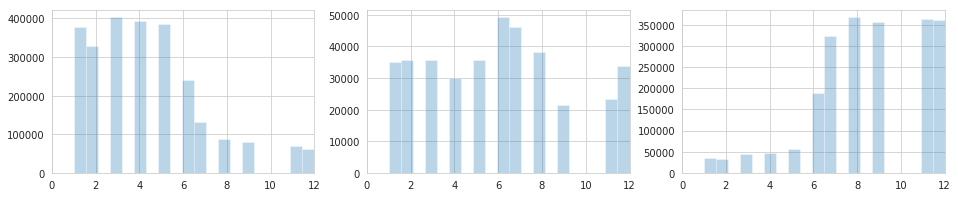

FLIGHT_NUMBER


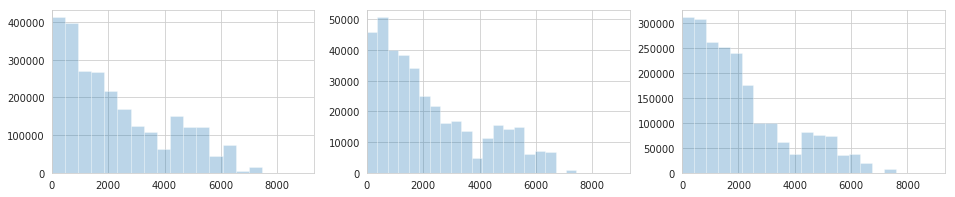

TAIL_NUMBER


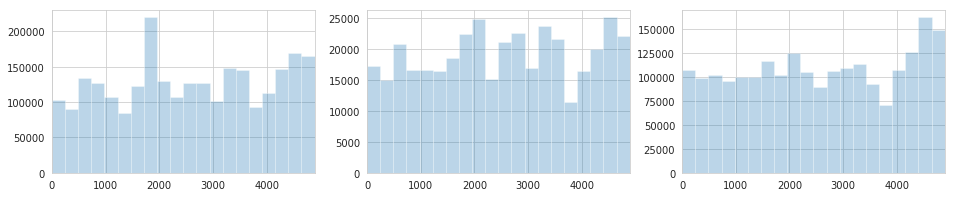

SCHEDULED_DEPARTURE


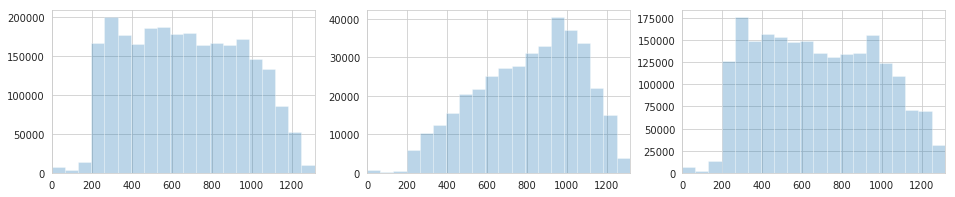

DEPARTURE_TIME


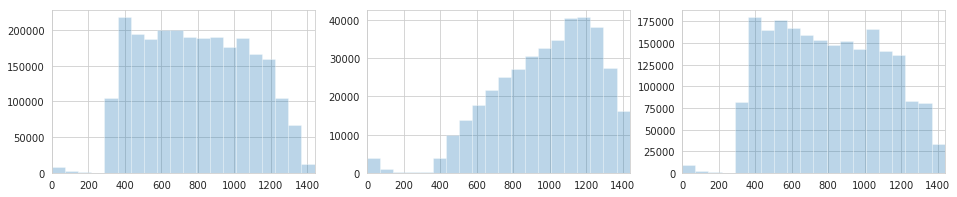

DEPARTURE_DELAY


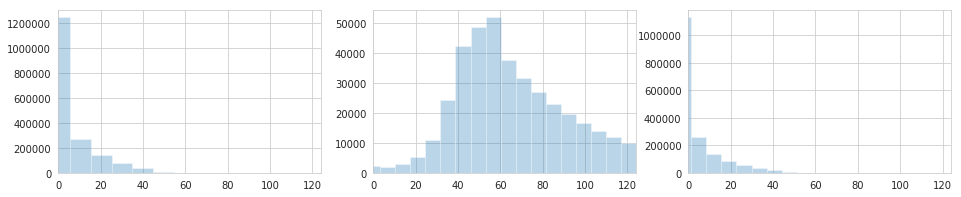

SCHEDULED_TIME


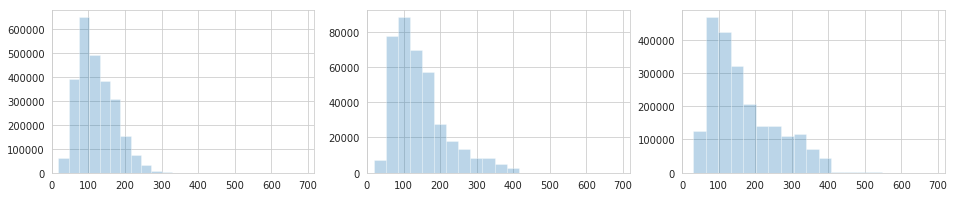

DISTANCE


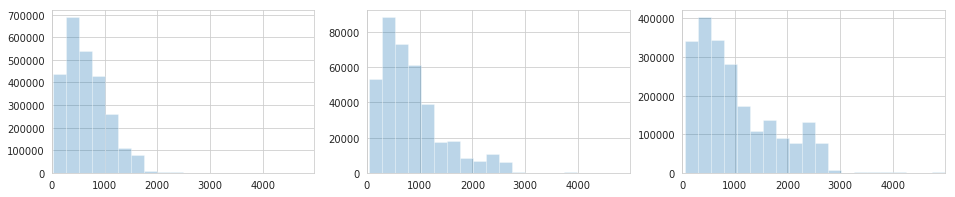

SCHEDULED_ARRIVAL


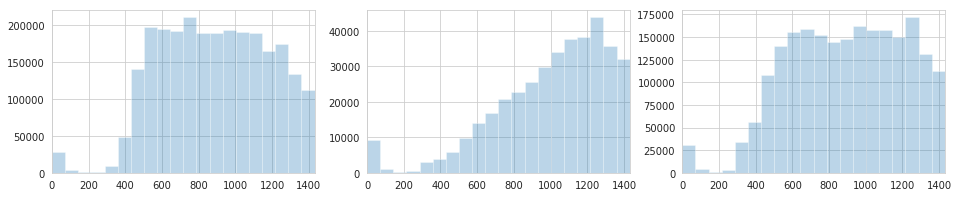

ARRIVAL_TIME


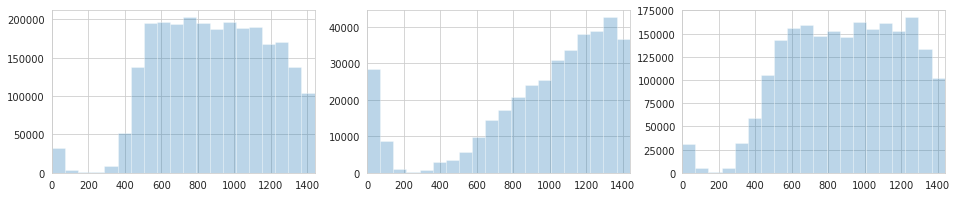

ARRIVAL_DELAY


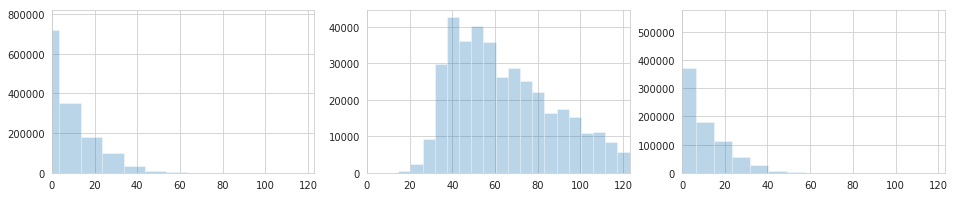

DIVERTED


/home/tiffany/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

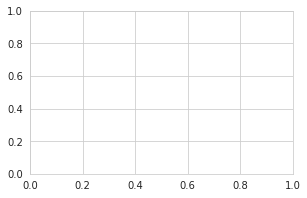

In [34]:
# Analyze the results
df_results = df_results.reset_index()
for cluster in sorted(set(kmeans.labels_)):
    print(collections.Counter(df_results[df_results['cluster']==cluster]['CANCELLATION_REASON']).most_common(5))

n_clusters = len(set(kmeans.labels_))
for col in X_columns:
    print(col)
    i = 1
    plt.figure(figsize=(16,3))
    for cluster in sorted(set(kmeans.labels_)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([0,df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
        i += 1
    plt.show()

In [41]:
# Analyze the centroids
df_results.groupby('cluster').mean().round(2).T

cluster,0,1,2
index,1776180.60,2574524.52,3819004.79
MONTH,4.31,5.96,8.53
FLIGHT_NUMBER,2259.72,2214.25,2052.04
TAIL_NUMBER,2570.64,2527.39,2557.23
SCHEDULED_DEPARTURE,667.13,806.09,679.68
DEPARTURE_TIME,790.99,978.19,801.93
DEPARTURE_DELAY,0.96,64.22,0.82
SCHEDULED_TIME,120.71,143.91,166.78
DISTANCE,658.13,839.10,1020.30
SCHEDULED_ARRIVAL,885.17,1004.14,893.85


#### Conclusions:
-On average cluster 1 has the highest number of flights cancelled due to schedualed departure time. 
-On average cluster 1 has the highest number of flights cancelled due to air system delays, airline delays, late aircraft delays and weather delays. 
-On average cluster 2 has the highest number of flights cancelled due to flight date.


MONTH


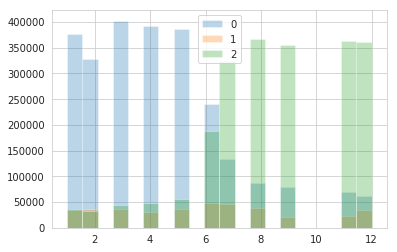

FLIGHT_NUMBER


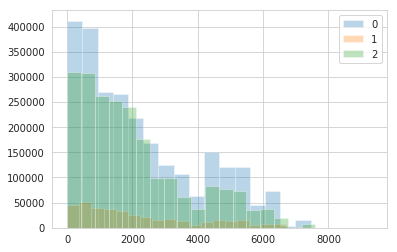

TAIL_NUMBER


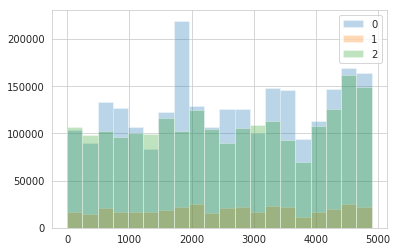

SCHEDULED_DEPARTURE


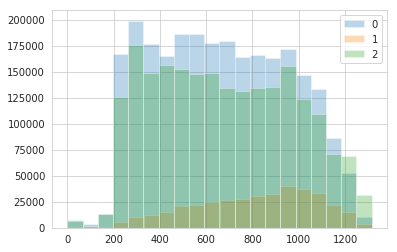

DEPARTURE_TIME


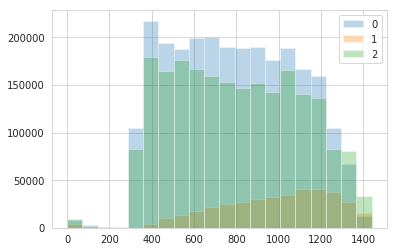

DEPARTURE_DELAY


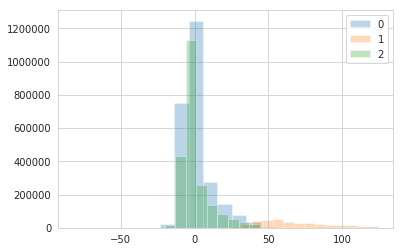

SCHEDULED_TIME


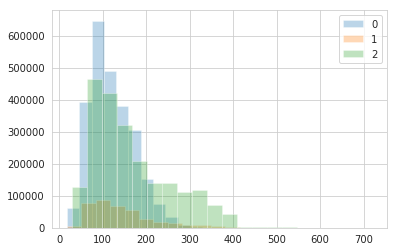

DISTANCE


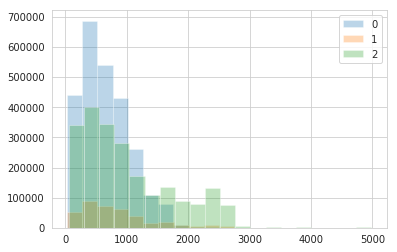

SCHEDULED_ARRIVAL


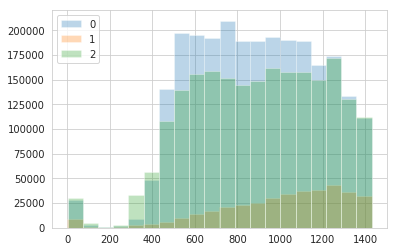

ARRIVAL_TIME


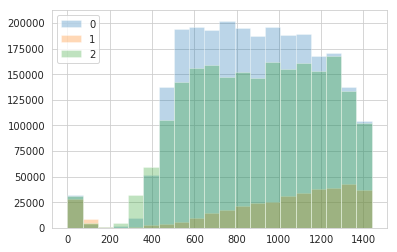

ARRIVAL_DELAY


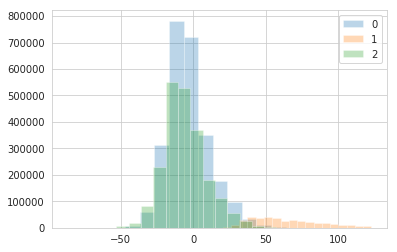

DIVERTED


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

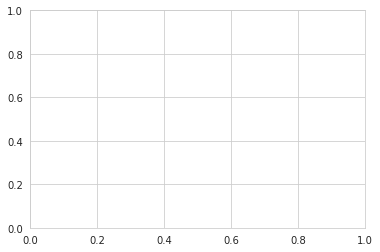

In [43]:
# Analyze the results
for col in X_columns:
    print(col)
    for cluster in set(kmeans.labels_):
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
    plt.legend()
    plt.show()

# Model Evaluation

In [44]:
# Inter-Cluster
centroids = []
for cluster in sorted(set(kmeans.labels_)):
    centroids.append(df_norm[df_norm['cluster']==cluster][X_columns].mean().values)
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])
print('Inter Cluster distance', np.mean(distances))

# Intra-Cluster
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])
print('Intra Cluster distance', np.mean(distances))

# Inertia
distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
print('Inertia', np.sum(distances))

Inter Cluster distance 0.5554470189002321
Intra Cluster distance 0.6348096631867215
Inertia 142448617.30986947


Conclusion:
 

In [45]:
inertia = []
number_k = []
for k in range(2, 100, 10):
    kmeans = KMeans(n_clusters=k).fit(df_norm.values)
    inertia.append(kmeans.inertia_)
    number_k.append(k)
plt.plot(number_k, inertia)
plt.show()

KeyboardInterrupt: 